# 线性模型的PyTorch实现

本节简单回顾一下线性回归模型，并演示一下如何使用PyTorch来对线性回归模型进行建模和模型参数计算。

## 1. 一元线性回归
一元线性回归模型比较简单，假设有变量 $x_i$ 和目标 $y_i$，每个 i 对应于一个数据点，希望建立一个模型

$$
\hat{y}_i = w x_i + b
$$

$\hat{y}_i$ 是预测的结果，希望通过 $\hat{y}_i$ 来拟合目标 $y_i$，通俗来讲就是找到这个函数拟合 $y_i$ 使得误差最小，即最小化

$$
\frac{1}{n} \sum_{i=1}^n(\hat{y}_i - y_i)^2
$$

那么如何最小化这个误差呢？

## 2. 梯度下降法

在梯度下降法中，首先要明确梯度的概念，梯度在数学上就是导数，如果是一个多元函数，那么梯度就是偏导数。比如一个函数$f(x, y)$，那么 $f$ 的梯度就是 

$$
(\frac{\partial f}{\partial x},\ \frac{\partial f}{\partial y})
$$

可以称为 grad f(x, y) 或者 $\nabla f(x, y)$。具体某一点 $(x_0,\ y_0)$ 的梯度就是 $\nabla f(x_0,\ y_0)$。


梯度有什么意义呢？从几何意义来讲，一个点的梯度值是这个函数变化最快的地方。具体来说，对于函数 f(x, y)，在点 $(x_0, y_0)$ 处，沿着梯度 $\nabla f(x_0,\ y_0)$ 的方向，函数增加最快，也就是说沿着梯度的方向，能够更快地找到函数的极大值点，或者反过来沿着梯度的反方向，能够更快地找到函数的最小值点。

针对一元线性回归问题，就是沿着梯度的反方向，不断改变 $w$ 和 $b$ 的值，最终找到一组最好的 $w$ 和 $b$ 使得误差最小。

在更新的时候，需要决定每次更新的幅度就是每次往下走的那一步的长度，这个长度称为学习率，用 $\eta$ 表示。不同的学习率都会导致不同的结果，学习率太小会导致下降非常缓慢；学习率太大又会导致跳动非常明显。

最后我们的更新公式就是

$$
w = w - \eta \frac{\partial f(w,\ b)}{\partial w} \\
b = b - \eta \frac{\partial f(w,\ b)}{\partial b}
$$

通过不断地迭代更新，最终我们能够找到一组最优的 $w$ 和 $b$。

## 3. PyTorch实现

上面是原理部分，下面通过一个例子来进一步学习线性模型

In [1]:
import torch
import numpy as np

torch.manual_seed(2021)

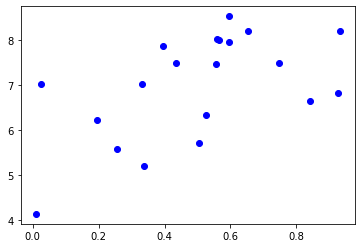

In [2]:
# 生层测试数据
x_train = np.random.rand(20, 1)
y_train = x_train * 3 + 4 + 3*np.random.rand(20,1)

# 画出图像
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x_train, y_train, 'bo')

In [3]:
# 转换成 Tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

# 定义参数 w 和 b
w = torch.randn(1, requires_grad=True) # 随机初始化
b = torch.zeros(1, requires_grad=True) # 使用 0 进行初始化

In [4]:
# 构建线性回归模型
def linear_model(x):
    return x * w + b

def logistc_regression(x):
    return torch.sigmoid(x*w+b) 

In [5]:
y_ = linear_model(x_train)

经过上面的步骤我们就定义好了模型，在进行参数更新之前，我们可以先看看模型的输出结果长什么样

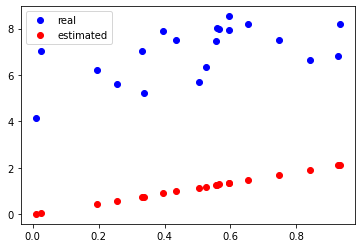

In [6]:
plt.plot(x_train.data.numpy(), y_train.data.numpy(), 'bo', label='real')
plt.plot(x_train.data.numpy(), y_.data.numpy(), 'ro', label='estimated')
plt.legend()

这个时候需要计算我们的误差函数，也就是

$$
E = \sum_{i=1}^n(\hat{y}_i - y_i)^2
$$

In [7]:
# 计算误差
def get_loss(y_, y):
    return torch.sum((y_ - y) ** 2)

loss = get_loss(y_, y_train)
print(loss)

tensor(704.5194, dtype=torch.float64, grad_fn=<SumBackward0>)


定义好了误差函数，接下来我们需要计算 $w$ 和 $b$ 的梯度了，这时得益于 PyTorch 的自动求导，不需要手动去算梯度就可以得到计算好的梯度值。手动计算的$w$ 和 $b$ 的梯度分别是

$$
\frac{\partial}{\partial w} = \frac{2}{n} \sum_{i=1}^n x_i(w x_i + b - y_i) \\
\frac{\partial}{\partial b} = \frac{2}{n} \sum_{i=1}^n (w x_i + b - y_i)
$$

In [8]:
# 自动求导
loss.backward()

In [9]:
# 查看 w 和 b 的梯度
print(w.grad)
print(b.grad)

tensor([-117.3280])
tensor([-234.3059])


In [10]:
# 更新一次参数
w.data = w.data - 1e-2 * w.grad.data
b.data = b.data - 1e-2 * b.grad.data

更新完成参数之后，我们再一次看看模型输出的结果

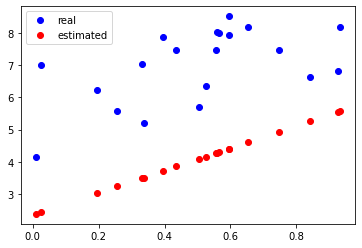

In [11]:
y_ = linear_model(x_train)
plt.plot(x_train.data.numpy(), y_train.data.numpy(), 'bo', label='real')
plt.plot(x_train.data.numpy(), y_.data.numpy(), 'ro', label='estimated')
plt.legend()

从上面的例子可以看到，更新之后红色的线跑到了蓝色的线下面，没有特别好的拟合蓝色的真实值，所以我们需要在进行几次更新

In [12]:
for e in range(100): # 进行 100 次更新
    y_ = linear_model(x_train)
    loss = get_loss(y_, y_train)
    
    w.grad.zero_() # 注意：归零梯度
    b.grad.zero_() # 注意：归零梯度
    loss.backward()
    
    w.data = w.data - 1e-2 * w.grad.data # 更新 w
    b.data = b.data - 1e-2 * b.grad.data # 更新 b 
    if (e + 1) % 20 == 0:
        print('epoch: {}, loss: {}'.format(e, loss.item()))

epoch: 19, loss: 21.218688263809952
epoch: 39, loss: 19.55484974487415
epoch: 59, loss: 18.824963796393106
epoch: 79, loss: 18.50477882805245
epoch: 99, loss: 18.364321569910107


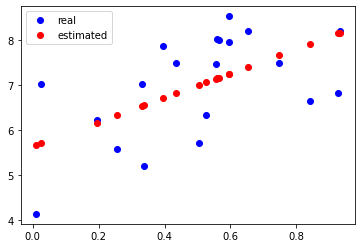

In [13]:
y_ = linear_model(x_train)
plt.plot(x_train.data.numpy(), y_train.data.numpy(), 'bo', label='real')
plt.plot(x_train.data.numpy(), y_.data.numpy(), 'ro', label='estimated')
plt.legend()

经过 100 次更新，可以发现红色的预测结果已经比较好的拟合了蓝色的真实值。

## 4. 多项式回归模型

下面更进一步尝试一下多项式回归，下面是关于 x 的多项式：

$$
\hat{y} = w_0 + w_1 x + w_2 x^2 + w_3 x^3 
$$

这样就能够拟合更加复杂的模型，这里使用了 $x$ 的更高次，同理还有多元回归模型，形式也是一样的，只是除了使用 $x$，还是更多的变量，比如 $y$、$z$ 等等，同时他们的 $loss$ 函数和简单的线性回归模型是一致的。

首先定义一个需要拟合的目标函数，这个函数是个三次的多项式

In [14]:
# 定义一个多变量函数

w_target = np.array([0.5, 3, 2.4]) # 定义参数
b_target = np.array([0.9]) # 定义参数

f_des = 'y = {:.2f} + {:.2f} * x + {:.2f} * x^2 + {:.2f} * x^3'.format(
    b_target[0], w_target[0], w_target[1], w_target[2]) # 打印出函数的式子

print(f_des)

y = 0.90 + 0.50 * x + 3.00 * x^2 + 2.40 * x^3


多项式的的曲线绘制

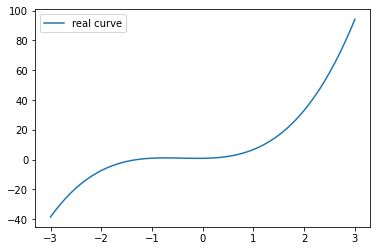

In [16]:
# 画出这个函数的曲线
x_sample = np.arange(-3, 3.1, 0.1)
y_sample = b_target[0] + w_target[0] * x_sample + w_target[1] * x_sample ** 2 + w_target[2] * x_sample ** 3

plt.plot(x_sample, y_sample, label='real curve')
plt.legend()

接着构建数据集，需要 x 和 y，同时是一个三次多项式，所以取 $x,\ x^2, x^3$

In [17]:
# 构建数据 x 和 y
# x 是一个如下矩阵 [x, x^2, x^3]
# y 是函数的结果 [y]

x_train = np.stack([x_sample ** i for i in range(1, 4)], axis=1)
x_train = torch.from_numpy(x_train).float() # 转换成 float tensor

y_train = torch.from_numpy(y_sample).float().unsqueeze(1) # 转化成 float tensor 

In [18]:
print(x_train.size())

torch.Size([61, 3])


接着定义需要优化的参数，就是前面这个函数里面的 $w_i$

In [19]:
# 定义参数
w = torch.randn((3, 1), dtype=torch.float, requires_grad=True)
b = torch.zeros((1), dtype=torch.float, requires_grad=True)

# 定义模型
def multi_linear(x):
    return torch.mm(x, w) + b

def get_loss(y_, y):
    return torch.mean((y_ - y) ** 2)

我们可以画出没有更新之前的模型和真实的模型之间的对比

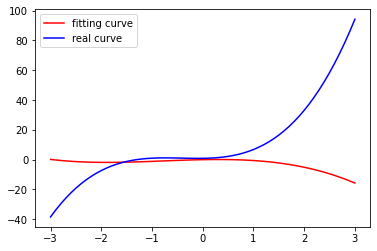

In [20]:
# 画出更新之前的模型
y_pred = multi_linear(x_train)

plt.plot(x_train.data.numpy()[:, 0], y_pred.data.numpy(), label='fitting curve', color='r')
plt.plot(x_train.data.numpy()[:, 0], y_sample, label='real curve', color='b')
plt.legend()

可以发现，这两条曲线之间存在差异，计算一下他们之间的误差

In [21]:
# 计算误差，这里的误差和一元的线性模型的误差是相同的，前面已经定义过了 get_loss
loss = get_loss(y_pred, y_train)
print(loss)

tensor(1144.2654, grad_fn=<MeanBackward0>)


In [22]:
# 自动求导
loss.backward()

In [23]:
# 查看一下 w 和 b 的梯度
print(w.grad)
print(b.grad)

tensor([[ -94.7455],
        [-139.1247],
        [-629.8584]])
tensor([-25.7413])


In [24]:
# 更新一下参数
w.data = w.data - 0.001 * w.grad.data
b.data = b.data - 0.001 * b.grad.data

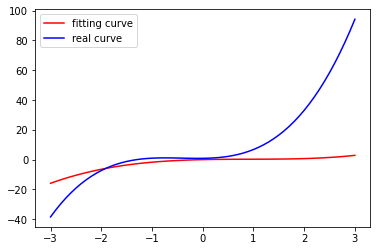

In [25]:
# 画出更新一次之后的模型
y_pred = multi_linear(x_train)

plt.plot(x_train.data.numpy()[:, 0], y_pred.data.numpy(), label='fitting curve', color='r')
plt.plot(x_train.data.numpy()[:, 0], y_sample, label='real curve', color='b')
plt.legend()

因为只更新了一次，所以两条曲线之间的差异仍然存在，下面进行 100 次迭代

In [26]:
# 进行 100 次参数更新
for e in range(100):
    y_pred = multi_linear(x_train)
    loss = get_loss(y_pred, y_train)
    
    w.grad.data.zero_()
    b.grad.data.zero_()
    loss.backward()
    
    # 更新参数
    w.data = w.data - 0.001 * w.grad.data
    b.data = b.data - 0.001 * b.grad.data
    if (e + 1) % 20 == 0:
        print('epoch {}, Loss: {:.5f}'.format(e+1, loss.data.item()))

epoch 20, Loss: 65.56586
epoch 40, Loss: 15.41177
epoch 60, Loss: 3.70702
epoch 80, Loss: 0.97122
epoch 100, Loss: 0.32874


可以看到更新完成之后 loss 已经非常小了，我们画出更新之后的曲线对比

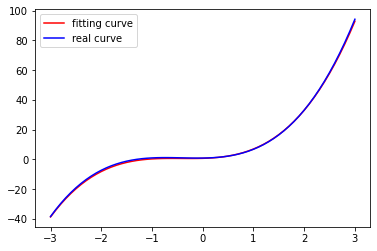

In [27]:
# 画出更新之后的结果
y_pred = multi_linear(x_train)

plt.plot(x_train.data.numpy()[:, 0], y_pred.data.numpy(), label='fitting curve', color='r')
plt.plot(x_train.data.numpy()[:, 0], y_sample, label='real curve', color='b')
plt.legend()

可以看到，经过 100 次更新之后，可以看到拟合的线和真实的线已经完全重合了

## 练习题

* 上面的例子是一个三次的多项式，尝试使用二次的多项式去拟合它，看看最后能做到多好
